## Part 2: Data Cleaning and EDA

In [2]:
import requests
import re
import pickle
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

from datetime import datetime
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [15]:
df = pd.read_pickle('./data/raw_scrap.pkl')

In [16]:
# filter out the columns that might be useful
df1 = df[['subreddit','selftext','title','created_utc']]
df1.shape

(3999, 4)

In [17]:
# Convert time from UTC format to readable format
df1['time'] = df1['created_utc'].apply(lambda x: datetime.fromtimestamp(x))
df1.drop(columns=['created_utc'],inplace=True)

C:\Users\pkfei\AppData\Local\Temp/ipykernel_64964/4224088693.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['time'] = df1['created_utc'].apply(lambda x: datetime.fromtimestamp(x))
C:\Users\pkfei\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [18]:
df1.head()

,subreddit,selftext,title,time
0,marvelstudios,,New Ms. Marvel show was crazy,2022-07-21 13:40:51
1,marvelstudios,"In that scene where 838 Wanda gets possesed, a...",Question about Dsmom.,2022-07-21 13:37:29
2,marvelstudios,I’d change the interconnectivity between the p...,What is one thing you’d change about the MCU?,2022-07-21 13:33:27
3,marvelstudios,Did anyone notice in the scene where Jane and ...,Thors Face in Thor LOT,2022-07-21 13:32:36
4,marvelstudios,\n\nWhy didn't Thor bring Mjolnir for the fina...,Thor 4 questions (spoilers),2022-07-21 13:27:45


In [19]:
df1.subreddit.value_counts()

DC_Cinematic     2000
marvelstudios    1999
Name: subreddit, dtype: int64

In [20]:
# Extract the hour and date from timestamp
df1['post_day'] = df1['time'].apply(lambda x: x.strftime('%A'))
df1['post_hour'] = df1['time'].apply(lambda x: x.hour)

C:\Users\pkfei\AppData\Local\Temp/ipykernel_64964/3827939193.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['post_day'] = df1['time'].apply(lambda x: x.strftime('%A'))
C:\Users\pkfei\AppData\Local\Temp/ipykernel_64964/3827939193.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['post_hour'] = df1['time'].apply(lambda x: x.hour)


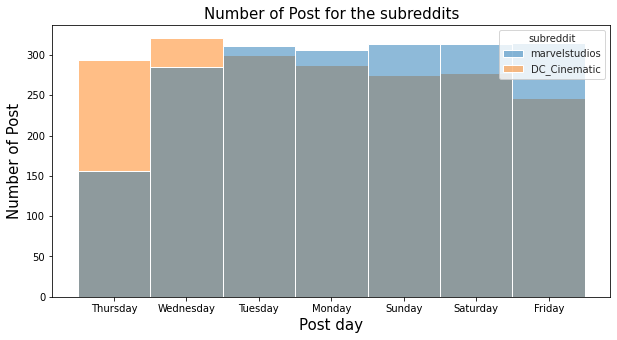

In [21]:
# Some EDA on the data collected time

fig, ax = plt.subplots(figsize=(10,5))
with sns.axes_style('white'):
  sns.histplot (data=df1, x='post_day', hue='subreddit', ax=ax)

plt.xlabel('Post day', fontsize=15)
plt.ylabel('Number of Post', fontsize=15)
plt.title('Number of Post for the subreddits', fontsize=15)
plt.show()


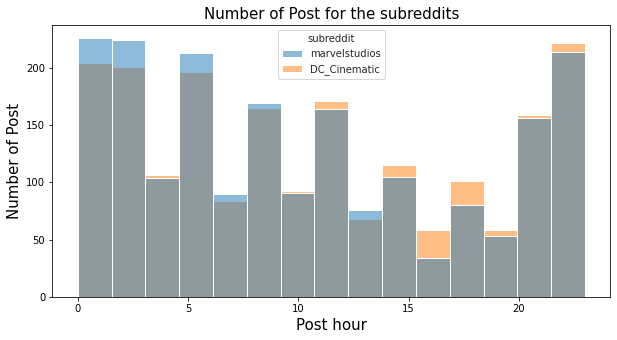

In [22]:
fig, ax = plt.subplots(figsize=(10,5))
with sns.axes_style('white'):
  sns.histplot (data=df1, x='post_hour', hue='subreddit', ax=ax)

plt.xlabel('Post hour', fontsize=15)
plt.ylabel('Number of Post', fontsize=15)
plt.title('Number of Post for the subreddits', fontsize=15)
plt.show()

The reddit users for both page like to post between 11pm to 2am

In [23]:
#investigate null value
df1.isnull().sum()

subreddit    0
selftext     1
title        0
time         0
post_day     0
post_hour    0
dtype: int64

In [24]:
df1.loc[df1[df1['selftext'].isnull()].index]

,subreddit,selftext,title,time,post_day,post_hour
1160,marvelstudios,NaN,Is Peter Parker smarter than Jane Foster in th...,2022-07-17 13:06:39,Sunday,13


In [25]:
df1.fillna("",inplace=True)
df1.isnull().sum()

C:\Users\pkfei\anaconda3\lib\site-packages\pandas\core\frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


subreddit    0
selftext     0
title        0
time         0
post_day     0
post_hour    0
dtype: int64

In [26]:
#Investigate the duplicated rows
df1.duplicated().value_counts()

False    3997
True        2
dtype: int64

In [27]:
df1.loc[df1[df1.duplicated()].index]['title']

1038    Thor Love &amp; Thunders unpopular opinion.
1727        all Ms Marvel title card from ep1 to 6.
Name: title, dtype: object

In [28]:
df1 = df1.drop_duplicates()
df1.reset_index(inplace=True,drop=True)

In [29]:
#Combine title and selftext as a single column and investigate
df1['words'] = df1['selftext'] + df1['title']
df2 = df1[['subreddit','title','words']]
df2.head()

,subreddit,title,words
0,marvelstudios,New Ms. Marvel show was crazy,New Ms. Marvel show was crazy
1,marvelstudios,Question about Dsmom.,"In that scene where 838 Wanda gets possesed, a..."
2,marvelstudios,What is one thing you’d change about the MCU?,I’d change the interconnectivity between the p...
3,marvelstudios,Thors Face in Thor LOT,Did anyone notice in the scene where Jane and ...
4,marvelstudios,Thor 4 questions (spoilers),\n\nWhy didn't Thor bring Mjolnir for the fina...


In [30]:
# Tokenise the columns
tokenizer = RegexpTokenizer(r'\w+')
df2['title_token'] = df2['title']
df2['title_selftext_token'] = df2['words']
for i in range(len(df2)):
  df2['title_token'][i] = tokenizer.tokenize(df2['title'][i].lower())
  df2['title_selftext_token'][i] = tokenizer.tokenize(df2['words'][i].lower())

C:\Users\pkfei\AppData\Local\Temp/ipykernel_64964/3859057490.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['title_token'] = df2['title']
C:\Users\pkfei\AppData\Local\Temp/ipykernel_64964/3859057490.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['title_selftext_token'] = df2['words']
C:\Users\pkfei\AppData\Local\Temp/ipykernel_64964/3859057490.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pand

In [31]:
# Evaluate the lenght of the columns of title and combined selftext+title
df2['Title_num'] = df2['title_token'].apply(lambda x: len(x))
df2['TotalWords_num'] = df2['title_selftext_token'].apply(lambda x: len(x))

C:\Users\pkfei\AppData\Local\Temp/ipykernel_64964/673526575.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Title_num'] = df2['title_token'].apply(lambda x: len(x))


Text(0.5, 1.0, 'Comparison of data between two classes')

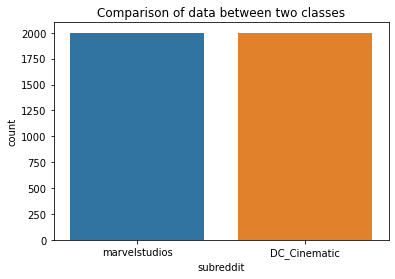

In [34]:
sns.countplot(x='subreddit', data=df2)
plt.title('Comparison of data between two classes')

No data imbalance issue here

In [35]:
df2.groupby('subreddit').sum()

,Title_num,TotalWords_num
subreddit,,
DC_Cinematic,23413,66249
marvelstudios,24664,144697


In [36]:
df2.groupby('subreddit').mean()

,Title_num,TotalWords_num
subreddit,,
DC_Cinematic,11.706500,33.124500
marvelstudios,12.350526,72.457186


In [37]:
df2.sort_values(by=['Title_num'],ascending=True).head()

,subreddit,title,words,title_token,title_selftext_token,Title_num,TotalWords_num
2587,DC_Cinematic,🤣,🤣,[],[],0,0
2589,DC_Cinematic,🤣,🤣,[],[],0,0
2588,DC_Cinematic,🤣,🤣,[],[],0,0
2000,DC_Cinematic,😂😂😂😂,😂😂😂😂,[],[],0,0
2262,DC_Cinematic,💀💀,💀💀,[],[],0,0


The columns with non words(title number/Total words=0) will be deleted. 

In [38]:
df2[(df2['Title_num']==0)|(df2['TotalWords_num']==0)].count()

subreddit               15
title                   15
words                   15
title_token             15
title_selftext_token    15
Title_num               15
TotalWords_num          15
dtype: int64

In [39]:
# Remove the non words rows
df2 = df2[(df2['Title_num']!=0)|(df2['TotalWords_num']!=0)]

In [40]:
df2.sort_values(by=['TotalWords_num'],ascending=False).head()

,subreddit,title,words,title_token,title_selftext_token,Title_num,TotalWords_num
781,marvelstudios,My extremely pretentious and stupidly bloated ...,Foreword: This is almost entirely a massive re...,"[my, extremely, pretentious, and, stupidly, bl...","[foreword, this, is, almost, entirely, a, mass...",13,2414
690,marvelstudios,"My MCU Phase 4 thoughts so far, amidst all the...","Alright, now that we're 13 projects into Phase...","[my, mcu, phase, 4, thoughts, so, far, amidst,...","[alright, now, that, we, re, 13, projects, int...",18,2168
306,marvelstudios,Thor: Love and Thunder Review/Revision Ideas,This past week I saw Thor: L&amp;T in theatres...,"[thor, love, and, thunder, review, revision, i...","[this, past, week, i, saw, thor, l, amp, t, in...",7,2024
977,marvelstudios,What do you guys think of the Wakanda Forever ...,# Black Panther: Wakanda Forever\n\nA [Wakanda...,"[what, do, you, guys, think, of, the, wakanda,...","[black, panther, wakanda, forever, a, wakanda,...",13,2013
2852,DC_Cinematic,I came up with 2 movies and typed them down fo...,Robin. It could either be a singular all encom...,"[i, came, up, with, 2, movies, and, typed, the...","[robin, it, could, either, be, a, singular, al...",13,1725


In [41]:
#Investigate the distribution of title and combined text

def dist_plot(data):
# select the columns to be plotted
  cols = ['Title_num', 'TotalWords_num']
  fig,ax = plt.subplots(figsize=(15,10))

  for i, col in enumerate(cols,1):
     with sns.axes_style('white'):
       plt.title(f"Dstribution of count of words",size=20,fontname="Times New Roman",fontweight="bold")
       plt.subplot(len(cols), 1, i)
       sns.histplot(data=data, x=col, hue='subreddit', kde=True)
       plt.xlabel('{}'.format(col), size=15,labelpad=12.5,fontweight="bold")
       #plt.legend(fontsize=12.5)
       plt.ylabel('Count', size=15, labelpad=12.5,fontweight="bold")
       plt.axvline(x = data[col].median(), color = 'b', label = df2[col].mean())
       plt.xlim([0,np.quantile(data[col],0.98)])
       

  for j in range(2):
       plt.tick_params(axis='x', labelsize=10)
       plt.tick_params(axis='y', labelsize=10)
       
  plt.show() 

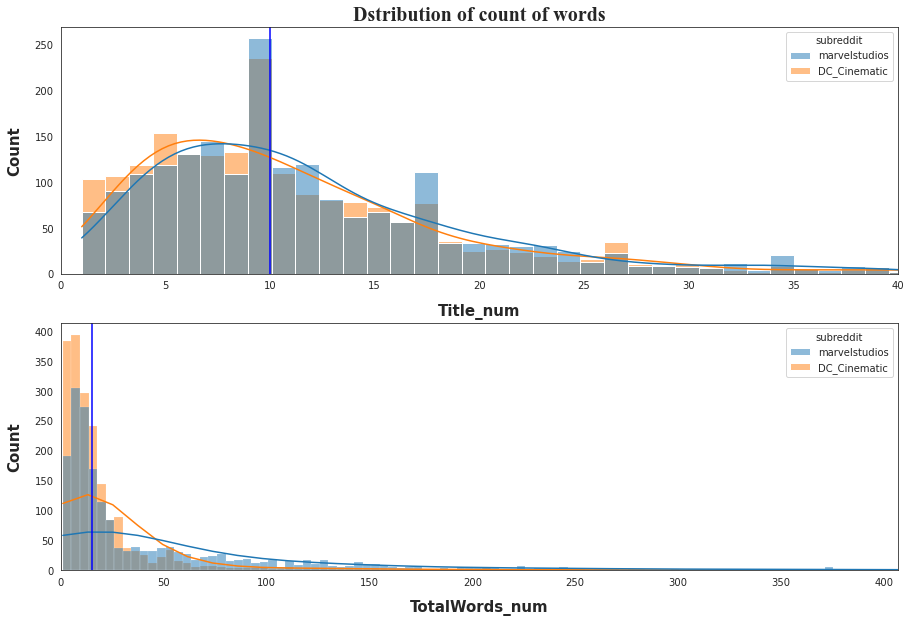

In [42]:
dist_plot(df2)

The distribution of words for both page are similar, especially for titles column, they have less outliers too.
Hence, the titles column will be taken as our feature in analysis

In [43]:
# Processing of the columns
# Join token and get only words using regex
df2['title_combined'] = df2['title_token'].apply(lambda x: ' '.join(word for word in x))
df2['title_combined'] = df2['title_combined'].str.replace(r'[\d\W_]+', ' ')

C:\Users\pkfei\AppData\Local\Temp/ipykernel_64964/1041219679.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df2['title_combined'] = df2['title_combined'].str.replace(r'[\d\W_]+', ' ')


In [44]:
df2.head()

,subreddit,title,words,title_token,title_selftext_token,Title_num,TotalWords_num,title_combined
0,marvelstudios,New Ms. Marvel show was crazy,New Ms. Marvel show was crazy,"[new, ms, marvel, show, was, crazy]","[new, ms, marvel, show, was, crazy]",6,6,new ms marvel show was crazy
1,marvelstudios,Question about Dsmom.,"In that scene where 838 Wanda gets possesed, a...","[question, about, dsmom]","[in, that, scene, where, 838, wanda, gets, pos...",3,45,question about dsmom
2,marvelstudios,What is one thing you’d change about the MCU?,I’d change the interconnectivity between the p...,"[what, is, one, thing, you, d, change, about, ...","[i, d, change, the, interconnectivity, between...",10,53,what is one thing you d change about the mcu
3,marvelstudios,Thors Face in Thor LOT,Did anyone notice in the scene where Jane and ...,"[thors, face, in, thor, lot]","[did, anyone, notice, in, the, scene, where, j...",5,78,thors face in thor lot
4,marvelstudios,Thor 4 questions (spoilers),\n\nWhy didn't Thor bring Mjolnir for the fina...,"[thor, 4, questions, spoilers]","[why, didn, t, thor, bring, mjolnir, for, the,...",4,53,thor questions spoilers


In [45]:
# Final dataframe
df3 = df2[['subreddit','title_combined']]

In [46]:
X1 = df3[df3['subreddit'] == 'marvelstudios']['title_combined']
y1 = df3[df3['subreddit' ]== 'marvelstudios']['subreddit']

X2 = df3[df3['subreddit'] == 'DC_Cinematic']['title_combined']
y2 = df3[df3['subreddit'] == 'DC_Cinematic']['subreddit']

C:\Users\pkfei\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


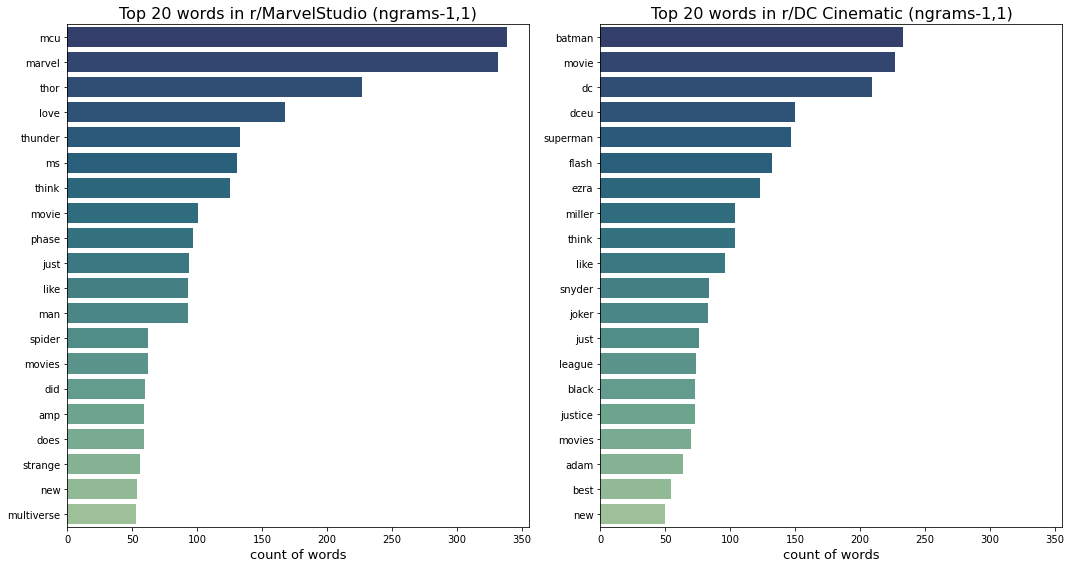

In [53]:
# Use countvectorizer to visualise the contents in the feature

cvec = CountVectorizer(stop_words='english')
X1_train = cvec.fit_transform(X1)
X1_train_df = pd.DataFrame(X1_train.todense(),                  
                          columns=cvec.get_feature_names())
X1_df = X1_train_df.sum().sort_values(ascending=False).head(200)



cvec2 = CountVectorizer(stop_words='english')
X2_train = cvec2.fit_transform(X2)
X2_train_df = pd.DataFrame(X2_train.todense(),                  
                          columns=cvec2.get_feature_names())
X2_df = X2_train_df.sum().sort_values(ascending=False).head(200)



# plot results
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,8), sharex = True)
sns.barplot(y=X1_df[0:20].index.values, x = X1_df[0:20],ax=ax[0],palette='crest_r')
ax[0].set_title('Top 20 words in r/MarvelStudio (ngrams-1,1)',fontsize=16)
ax[0].set_xlabel('count of words', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=10)

sns.barplot(y=X2_df[0:20].index.values, x = X2_df[0:20],ax=ax[1],palette='crest_r')
ax[1].set_title('Top 20 words in r/DC Cinematic (ngrams-1,1)',fontsize=16)
ax[1].set_xlabel('count of words', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=10)

plt.tight_layout()

C:\Users\pkfei\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


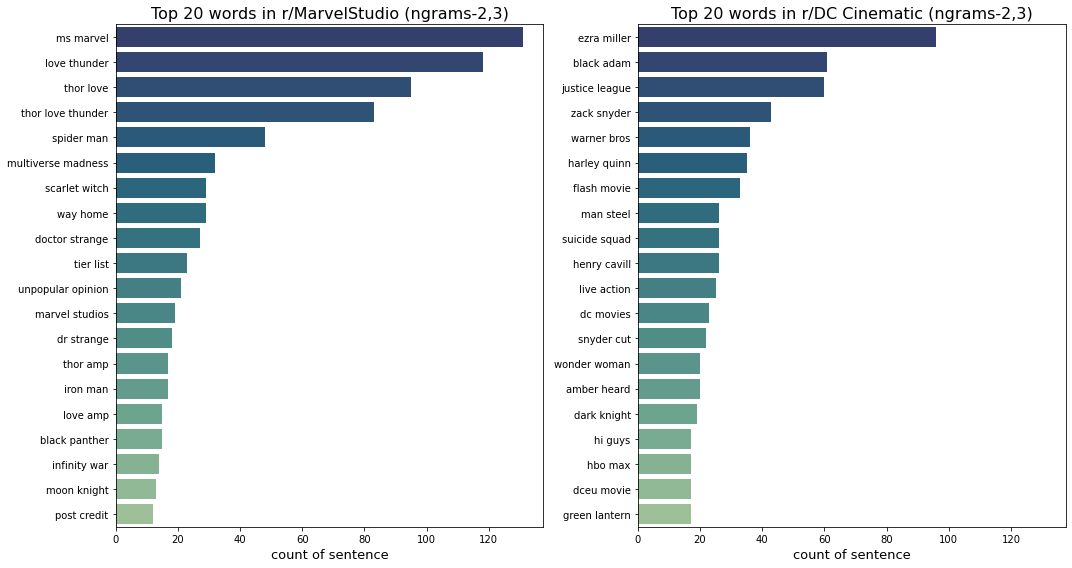

In [49]:
cvec = CountVectorizer(stop_words='english',ngram_range=(2,3))
X1_train = cvec.fit_transform(X1)
X1_train_df = pd.DataFrame(X1_train.todense(),                  
                          columns=cvec.get_feature_names())
X1_df = X1_train_df.sum().sort_values(ascending=False).head(200)



cvec2 = CountVectorizer(stop_words='english',ngram_range=(2,3))
X2_train = cvec2.fit_transform(X2)
X2_train_df = pd.DataFrame(X2_train.todense(),                  
                          columns=cvec2.get_feature_names())
X2_df = X2_train_df.sum().sort_values(ascending=False).head(200)



# plot results
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,8), sharex = True)
sns.barplot(y=X1_df[0:20].index.values, x = X1_df[0:20],ax=ax[0],palette='crest_r')
ax[0].set_title('Top 20 words in r/MarvelStudio (ngrams-2,3)',fontsize=16)
ax[0].set_xlabel('count of sentence', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=10)

sns.barplot(y=X2_df[0:20].index.values, x = X2_df[0:20],ax=ax[1],palette='crest_r')
ax[1].set_title('Top 20 words in r/DC Cinematic (ngrams-2,3)',fontsize=16)
ax[1].set_xlabel('count of sentence', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=10)

plt.tight_layout()

In [50]:
# Create stopword list:
stopwords = set(STOPWORDS)

# Wordcloud visualisation
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate_from_frequencies(data)

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

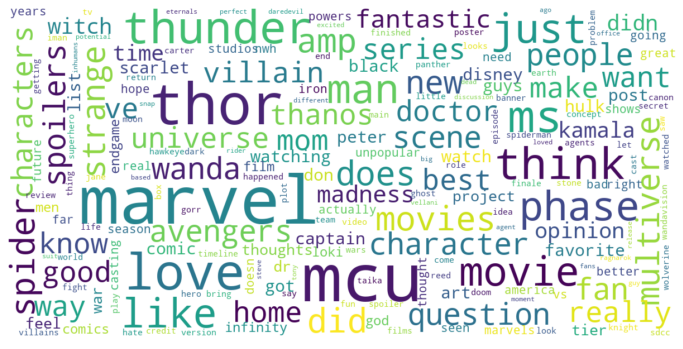

In [54]:
# For subreddit 1 - Marvel
show_wordcloud(X1_df)

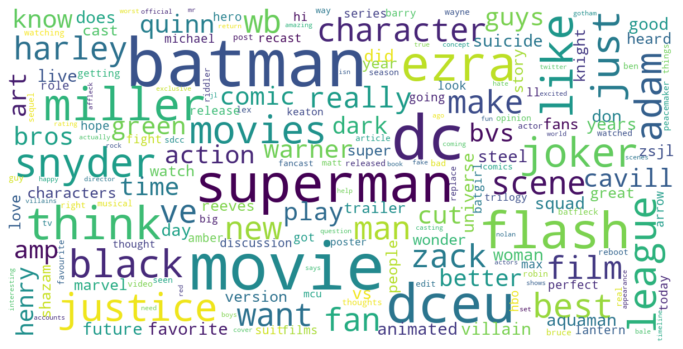

In [55]:
#For subreddit 2: DC
show_wordcloud(X2_df)

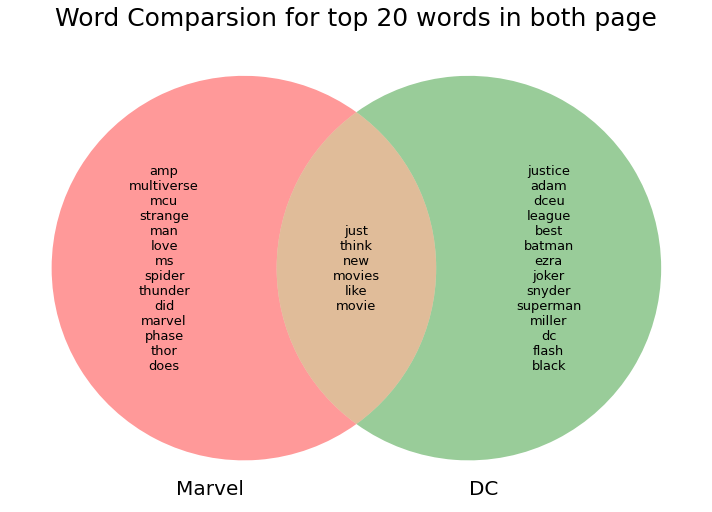

In [57]:
plt.figure(figsize=(10,10))
plt.title('Word Comparsion for top 20 words in both page',fontsize=25)

X1_set = set(X1_df[0:20].index)
X2_set = set(X2_df[0:20].index)

venn = venn2([X1_set,X2_set],set_labels=['Marvel','DC'])

venn.get_label_by_id('100').set_text('\n'.join(map(str,X1_set-X2_set)))
venn.get_label_by_id('110').set_text('\n'.join(map(str,X1_set&X2_set)))
venn.get_label_by_id('010').set_text('\n'.join(map(str,X2_set-X1_set)))

venn.get_label_by_id('A').set_size(20)
venn.get_label_by_id('B').set_size(20)
venn.get_label_by_id('100').set_size(13)
venn.get_label_by_id('110').set_size(13)
venn.get_label_by_id('010').set_size(13)

plt.tight_layout()



The common words will be treated as stopwords in building model to improve model predictiveness

In [40]:
df3.to_pickle('./data/cleaned.pkl')